# Visão Computacional - Tech Challenge 5  
## Pós-Tech em Inteligência Artificial - FIAP  
### Augusto Vieira Favi  

---

### Introdução  

Neste projeto, explorarei o uso de Inteligência Artificial para aumentar a segurança em estabelecimentos e comércios, implementando uma funcionalidade em monitoramento de câmeras de segurança. A proposta visa detectar objetos cortantes (como facas e tesouras) em tempo real, emitindo alertas preventivos para situações potencialmente perigosas.  

O projeto é estruturado em quatro objetivos principais:  

1. **Utilização de Dataset do Kaggle**: Para o treinamento do modelo, estou utilizando um dataset disponível no Kaggle, chamado ["Knife Dataset"](https://www.kaggle.com/datasets/shank885/knife-dataset). Esse dataset contém imagens de objetos cortantes em diversas condições de ângulo e iluminação, incluindo imagens negativas (sem objetos perigosos) para minimizar falsos positivos.  

2. **Treinamento do Modelo**: Utilizar algoritmos de aprendizado supervisionado para treinar o modelo de detecção de objetos cortantes com alta precisão.  

3. **Desenvolvimento de Sistema de Alertas**: Implementar um sistema de notificação em tempo real, como o envio de alertas por e-mail para a central de segurança.  

4. **Validação e Testes**: Validar o modelo utilizando vídeos de teste fornecidos, garantindo a eficácia da detecção em cenários reais. \

## **Imports**

In [1]:
import os
import cv2
import shutil
import time
import smtplib
import numpy as np
import tempfile
import matplotlib.pyplot as plt

from ultralytics import YOLO
from pathlib import Path
from datetime import datetime
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

# Verify dataset structure
dataset_path = './datasets/knife-dataset'

def read_secret(file_path):
    try:
        with open(file_path, "r") as secret_file:
            secret = secret_file.read().strip()
        return secret
    except FileNotFoundError:
        print(f"Secret file not found at {file_path}")
    except Exception as e:
        print(f"Error reading secret file: {e}")
    return None

## IMPORTANDO MODELO


image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/24_jpg.rf.306e284994f7f6275d7772062debc4b5.jpg: 640x640 1 knife, 68.4ms
Speed: 2.5ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/knife_974_jpg.rf.36d132855d448a0e0f47458bfe893f27.jpg: 640x640 1 knife, 54.5ms
Speed: 1.9ms preprocess, 54.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/augusto.favi/Desktop/Tech Challenge 5/datasets/knife-dataset/valid/images/263_jpg.rf.2bef9f800f70185f747eddb69aff28ac.jpg: 640x640 1 knife, 54.7ms
Speed: 1.4ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


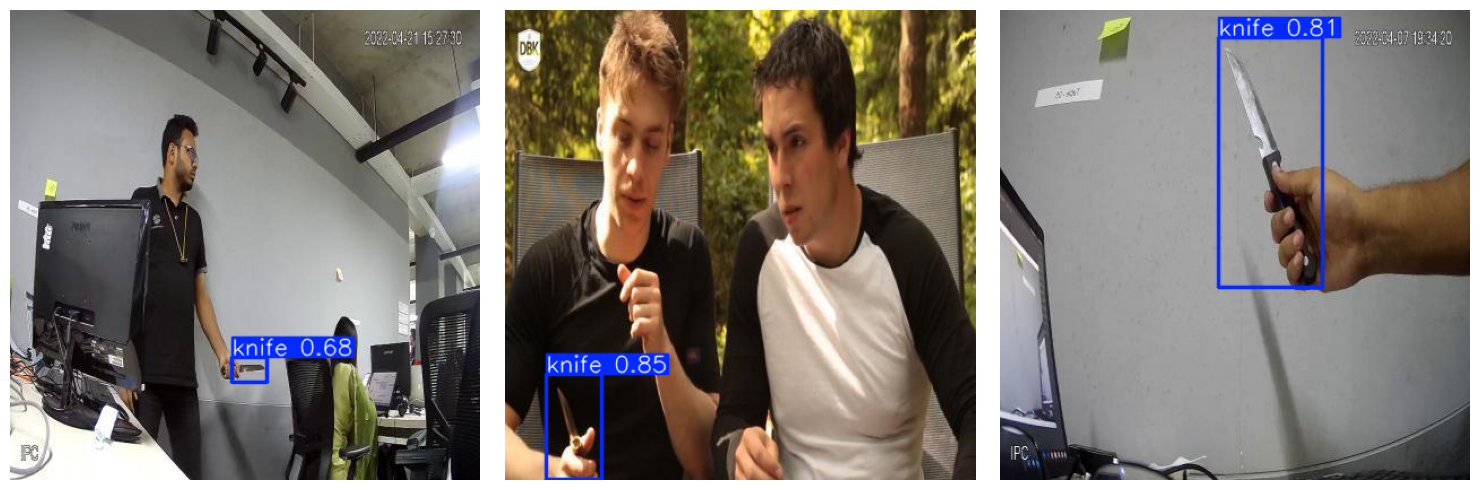

In [7]:
def show_predictions(model, dataset_path, split='valid'):
    img_dir = os.path.join(dataset_path, split, 'images')
    plt.figure(figsize=(15, 5))
    
    for i in range(3):
        img_path = os.path.join(img_dir, np.random.choice(os.listdir(img_dir)))
        results = model.predict(img_path, conf=0.5)

        # Ensure plot() returns an image
        annotated_img = results[0].plot()
        if annotated_img is not None:
            annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 3, i + 1)
            plt.imshow(annotated_img)
            plt.axis('off')
        else:
            print(f"Warning: plot() returned None for {img_path}")

    plt.tight_layout()
    plt.show()

# Call function
show_predictions(model, dataset_path)

## Processa vídeos de avaliação

In [10]:
def process_video(model, input_path, output_path, conf_threshold=0.6):
    cap = cv2.VideoCapture(str(input_path))
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
            
        # Perform detection
        results = model.predict(frame, conf=conf_threshold, verbose=False)
        
        # Draw only bounding boxes
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
        # Add alert overlay if detected
        if len(results[0].boxes) > 0:
            cv2.putText(frame, "ALERTA! FACA DETECTADA", 
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        (0, 0, 255), 2, cv2.LINE_AA)
            frame = cv2.addWeighted(
                frame, 1.2, 
                np.zeros_like(frame), 0, 0
            )
            
        out.write(frame)
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
# Define input and output paths
video_files = ["valuation_videos/video.mp4", "valuation_videos/video2.mp4"]
output_files = ["valuation_videos/marked_video.mp4", "valuation_videos/marked_video2.mp4"]

for input_path, output_path in zip(video_files, output_files):
    process_video(model, input_path, output_path)


In [5]:
def live_detection(model, conf_threshold=0.5, sender_email=None, sender_password=None, 
                   recipient_email="augusto.favi@gmail.com", smtp_server="smtp.gmail.com", 
                   smtp_port=587):
    cap = cv2.VideoCapture(0)
    last_email_sent_time = 0  # Initialize cooldown timer

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Perform detection
        results = model.predict(frame, conf=conf_threshold, verbose=False)
        annotated_frame = results[0].plot()

        # Check for knife detections
        knife_detected = False
        if len(results[0].boxes) > 0:
            classes = results[0].boxes.cls.cpu().numpy().astype(int)
            knife_detected = any(model.names[cls] == 'knife' for cls in classes)

        if knife_detected:
            # Visual alert
            cv2.putText(annotated_frame, "ALERTA! FACA DETECTADA", 
                        (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        (0, 0, 255), 2, cv2.LINE_AA)
            annotated_frame = cv2.addWeighted(
                annotated_frame, 1.2, 
                np.zeros_like(annotated_frame), 0, 0
            )

            # Save detected frame to a temporary file
            with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as temp_image:
                cv2.imwrite(temp_image.name, annotated_frame)
                image_path = temp_image.name

            # Email alert with cooldown
            current_time = time.time()
            if (current_time - last_email_sent_time) >= 60 and sender_email and sender_password:
                try:
                    msg = MIMEMultipart()
                    msg['From'] = sender_email
                    msg['To'] = recipient_email
                    msg['Subject'] = "ALERTA: Faca Detectada - VisionGuard"
                    
                    body = """
                    <html>
                      <body>
                        <p>Uma faca foi detectada pelo sistema VisionGuard!</p>
                        <p><b>Detalhes:</b><br>
                        - Horário da detecção: {time}<br>
                        - Confiança da detecção: {conf}%<br>
                        </p>
                        <p>Verifique imediatamente a situação.</p>
                      </body>
                    </html>
                    """.format(time=time.strftime('%d/%m/%Y %H:%M:%S'),
                             conf=int(max(results[0].boxes.conf.cpu().numpy())*100))

                    msg.attach(MIMEText(body, 'html', 'utf-8'))
                    
                    # Attach the image
                    with open(image_path, "rb") as attachment:
                        part = MIMEBase("application", "octet-stream")
                        part.set_payload(attachment.read())
                        encoders.encode_base64(part)
                        part.add_header(
                            "Content-Disposition",
                            f"attachment; filename=detected_frame.jpg",
                        )
                        msg.attach(part)

                    with smtplib.SMTP(smtp_server, smtp_port) as server:
                        server.starttls()
                        server.login(sender_email, sender_password)
                        server.sendmail(sender_email, recipient_email, msg.as_string())
                    
                    last_email_sent_time = current_time
                    print(f"Alerta enviado para {recipient_email}")
                except Exception as e:
                    print(f"Erro no envio de email: {str(e)}")

        cv2.imshow('VisionGuard Detection', annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

live_detection(model, sender_email=read_secret("./secrets/email"), sender_password=read_secret("./secrets/pass"))